In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from urllib.request import urlopen

In [2]:
random.seed(11)
np.random.seed(11)

In [3]:
with open('mnist.pkl', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(28, 28)
5


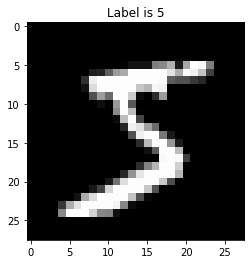

In [4]:
train_images = train_set[0]
train_labels = train_set[1]

test_images = test_set[0]
test_labels = test_set[1]

# Check that we have the expected shape of arrays, should be (50000, 784), (50000,), (10000, 784), (10000,)
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

#Plot the first training image and label
train_sample1 = train_images[0,:]
train_sample1 = train_sample1.reshape((28, 28))
label = train_labels[0]
print(train_sample1.shape)
print(label)

plt.title('Label is {label}'.format(label=label))
plt.imshow(train_sample1, cmap='gray')
plt.show()

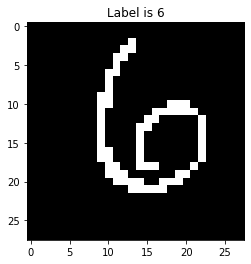

In [5]:
def sig(x):
    '''
    Sigmoid function
    '''
    return 1/(1 + np.exp(-x))

def plot(image, label=None):
    '''
    Plot image
    '''
    if len(image.shape) == 1:
        size = int(np.sqrt(image.shape[0]))
        image = image.reshape((size, size))
    elif image.shape[1] == 1:
        size = int(np.sqrt(image.shape[0]))
        image = image.reshape((size, size))
    if label:
        plt.title(f'Label is {label}')
    plt.imshow(image, cmap='gray')
    plt.show()
    
def to_binary(images, threshold=0.5):
    '''
    Convert images to binary
    '''
    images[images >= threshold] = 1
    images[images < threshold] = 0
    return images

# Convert all images to binary
to_binary(train_images)
to_binary(test_images)

# Images are now binary
plot(test_images[100,:].reshape((28, 28)), test_labels[100])

In [6]:
class BoltzmannMachine:
    '''
    Boltzmann machine class
    '''
    
    # The initialization function for the boltzmann machine
    def __init__(self, train_images, test_images, H_size=None, H=None):
        '''
        Parameters:
            train_images: numpy array of all training images
            test_images : numpy array of all test images
            H_size      : number of hidden units
            H           : custom hidden unit activations (optional)
        '''
        # All activations
        self.A = self.init_A(train_images, H_size, H)        
        
        # Visible and hidden units
        self.V = self.A[: train_images[0].shape[0], :]
        self.H = self.A[train_images[0].shape[0] :, :]
        
        # Total number of units
        self.n = self.A.shape[0]
        
        # Random weights
        self.W = self.init_W()
        
        # Random thresholds
        self.Theta = np.random.randn(self.n, 1)
        
        # Train and test images
        self.train_images = train_images
        self.test_images = test_images
        self.train_size = train_images.shape[0]
        
    # The function for Gibbs sampling
    def gibbs(self, AA, A, phase, gibbs_iters, T, verbose):
        '''
        Gibbs sampling.
        Sample random units then update activations,
        co-activation matrix, and activation count vector
        
        Parameters:
            AA         : 2 x n x n numpy array, for 2 co-activation matrices (1 for dream and 1 for wake)
            A          : 2 x n x 1 numpy array, for 2 activation count vectors
            phase      : 0 for wake, 1 for dream
            gibbs_iters: gibbs_iters[phase] for number of times to sample for corresponding phase
            T          : temperature
            verbose    : verbose flag
        '''        
        # Chose `gibbs_iters` random units
        units = np.random.randint(
            low=self.V.shape[0] if phase == 0 else 0, # During wake phase, update hidden units only
            high=self.n,
            size=gibbs_iters)
        
        # Transpose of activations for faster computations
        At = self.A.T

        # Number of Gibbs samples per clamped image
        iters_per_img = int(gibbs_iters / self.train_size)

        # Begin Gibbs sampling
        for i in range(gibbs_iters):
            if phase == 0 and i % iters_per_img == 0:
                # Clamp image if wake phase
                img_idx = int(i/iters_per_img)
                self.clamp(img_idx)
                
                if verbose and (img_idx+1) % 25000 == 0:
                    print(f'At train image {img_idx}...')
            
            # Probability that unit i is activated        
            pai = self.pai(units[i],T)
            
            # Update state of unit i
            self.A[units[i]] = 1 if np.random.rand() <= pai else 0
            At[0, units[i]] = self.A[units[i], 0]

            # Update cooactivaion and activation count
            AA[phase, At[0]==1] += At
            A[phase] += self.A
            
        # Average cooactivaion and activation count
        AA[phase] /= gibbs_iters
        A[phase] /= gibbs_iters
        
        return AA, A
    
    # The function for training the boltzmann machine
    def train(self, anneal_sched=[1], iters=100, gibbs_iters=None, eta=1, verbose=False):
        '''
        Go through `iters` Wake-dream cycles,
        perform Gibbs sampling, and update weights and biases
            
        Print loss values on training set
        
        Parameters:
            anneal_sched: annealing schedule
            iters       : number of iterations
            gibbs_iters : tuple containing number of time to Gibbs sample for wake and dream phases
            eta         : learning rate
            verbose     : verbose flag
        '''
        if not gibbs_iters:
            gibbs_iters = (self.train_size*10, self.n*100)
        
        # Coactivation matrices:
        #     AA[0,i,j] = # times ai == aj == 1 during wake phase
        #     AA[1,i,j] = # times ai == aj == 1 during dream phase
        AA = np.zeros((2, self.n, self.n))

        # Activition count:
        #     A[0, i] = # times ai == 1 during wake phase
        #     A[1, i] = # times ai == 1 during dream phase
        A = np.zeros((2, self.n, 1))
        
        # Constant term of loss
        L_const = np.log(1/self.train_size)
        
        wake, dream = 0, 1
        
        # for T in anneal_sched:
        # for i in range(T_iterations):

        print('Annealing schedule size:', len(anneal_sched))
        print('Number of iterations:', iters)
        iters_per_T = int(iters / len(anneal_sched))

        for i in range(iters):
            if verbose:
                print(f'Iteration {i}:')
            T = anneal_sched[int(i / iters_per_T)]
 
            for phase in [wake, dream]:
                if verbose:
                    print(f'{"Wake" if phase == 0 else "Dream"} phase')

                # Gibbs sampling
                self.gibbs(AA, A, phase, gibbs_iters[phase], T, verbose)

                # Reset activations by randomizing
                self.reset_A()

            # Update weights and biases
            self.W += eta*(AA[wake] - AA[dream])/T
            self.Theta += eta*(A[wake] - A[dream])/T

            # Calculate loss

            # Probabilities that visible units are activated
            pav_dream = self.pav(A[dream], T)

            # Sum of log probababilities of each image
            log_pv_dream = 0
            for img in self.train_images:
                log_pv_dream += self.log_pvk(pav_dream, img)
            log_pv_dream /= self.train_size

            # Print loss
            L = L_const - log_pv_dream
            print('Loss:', L, '\n')

            # Reset co-activation matrices and average activation vectors
            AA[:] = 0
            A[:] = 0
    
    def clamp(self, image):
        '''
        Clamp image to visible units
        '''
        if isinstance(image, int):
            image = self.train_images[image]
        self.V[:] = image.reshape((image.shape[0], 1))[:]
    
    
    # The function for testing the boltzmann machine
    def test(self, test_images):
        '''
        This function must print out the loss values on the test set.
        Comment!!!! Your marks depend on it!
        '''
        pass
    
    # The function for testing the boltzmann machine
    def test(self):
        """
        This function must return a numpy array of generated images.
        Comment!!!! Your marks depend on it!
        """
        pass
    
    def pai(self, i, T):
        '''
        Probability that unit i is activated (ai = 1)
        '''
        WiA = self.W[i,:].dot(self.A)
        return sig((WiA + self.Theta[i,:])/T)[0]

    def log_pvk(self, pav, img):
        '''
        Log probability of image
        '''
        pav[img==0] = 1 - pav[img==0]
        log_pvk = np.sum(np.log(pav))

        return log_pvk
    
    def pav(self, A=None, T=1):
        '''
        Probabilities that visible units are activated
        given the hidden units + weights
        '''
        if A is None:
            A = self.A
            
        WV = self.W[:self.V.shape[0],:]
        ThetaV = self.Theta[:self.V.shape[0],:]
        
        return sig((WV.dot(A) + ThetaV)/T)
        
    def init_A(self, train_images, H_size, H):
        '''
        Initizialize binary state/activation of all units
        '''
        V = np.random.randint(2, size=(train_images[0].shape[0], 1))
        
        if H is None:
            try:
                H = np.random.randint(2, size=(H_size, 1))
            except:
                raise ValueError('If H array not specified, specify H_size as int')
        
        A = np.append(V, H, axis=0)
        
        return A
    
    def reset_A(self):
        '''
        Reset activation vectors
        '''
        self.A[:] = np.random.randint(2, size=(self.n, 1))[:]
    
    def init_W(self):
        '''
        Initialize random weights matrix W
        '''
        # Randomize weights according to Gaussian distribution
        W = np.random.randn(self.n, self.n)
        
        # Symmetric weights: Wij = Wji
        W = np.tril(W) + np.tril(W, -1).T
        
        # Each node has no weight for itself: Wii = 0
        np.fill_diagonal(W, 0)
        
        # Visible units have no weights connecting between themselves
        W[:self.V.shape[0], :self.V.shape[0]] = 0 
        
        return W

In [7]:
# Create a Boltzmann machine and train it
boltzmann = BoltzmannMachine(train_images, test_images, H_size=10)

anneal_sched = [i for i in range(20,20+10*100,10)]
# anneal_sched = [i for i in range(109,9,-1)]
print(f'Annealing schedule: {anneal_sched}')
boltzmann.train(
    anneal_sched,
    iters=100,
    gibbs_iters=[boltzmann.train_size*1, boltzmann.n*1],
    eta=5,
    verbose=True
)

Annealing schedule: [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010]
Annealing schedule size: 100
Number of iterations: 100
Iteration 0:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 1116.72222751253 

Iteration 1:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 800.4280055160426 

Iteration 2:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 704.3485052473912 

Iteration 3:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 650.7138425

At train image 24999...
At train image 49999...
Dream phase
Loss: 536.8902000435367 

Iteration 70:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.8453707327623 

Iteration 71:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.466550875587 

Iteration 72:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.7479680536374 

Iteration 73:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.4656919667801 

Iteration 74:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.8337473459236 

Iteration 75:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.518977412996 

Iteration 76:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 536.2635649333133 

Iteration 77:
Wake phase
At train image 24999...
At train image 49999...
Dream phase
Loss: 535.8506957004257 

Iteration 78:
Wake phase
At 